Rate of return is discount rate at which NPV=0

For a standard cash flow, 1 investment is followed by a revenue stream

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cashflows = [-3000 for i in range(3)] +\
             [2000 for i in range(20)]
#cashflows

In [3]:
def NPV(undiscounted_cashflow, discount_rate):
    discounted_cashflow = [item / (1 + discount_rate)**i for i,item in enumerate(undiscounted_cashflow)]
    return sum(discounted_cashflow)
    #return discounted_cashflow

NPV(undiscounted_cashflow = cashflows, discount_rate = 0.01)

26468.78338647278

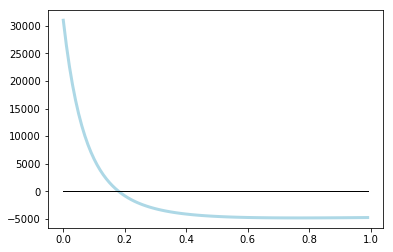

In [4]:
discount_rates = [i/100 for i in range(100)]
NPVs = [NPV(cashflows, i) for i in discount_rates]
plt.plot(discount_rates, NPVs, color='lightblue', linewidth=3)
plt.plot(discount_rates, [0 for i in discount_rates], color='black', linewidth=1)
plt.show()

Now lets do a pure acceleration

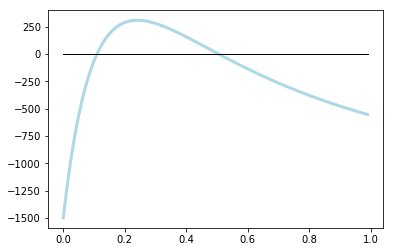

In [5]:
cashflows = ([-1500 for i in range(1)] +
             [1000 for i in range(5)] +
             [-1000 for i in range(5)])

NPVs = [NPV(cashflows, i) for i in discount_rates]
plt.plot(discount_rates, NPVs, color='lightblue', linewidth=3)
plt.plot(discount_rates, [0 for i in discount_rates], color='black', linewidth=1)
plt.show()

Pretty self-explanatory:
<br>2 roots. Can't use ROR, just use NPV at your cost of capital.

What about aggregating several projects, none of which are pure acceleration?
<br>https://www.me.utexas.edu/~me353/lessons/S2_Evaluation/L05_RateReturn/non_simple.html
<br>https://xplaind.com/405946/multiple-irrs

[-100, 405, -500, 200, -100, 100]
5


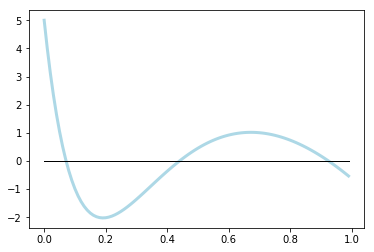

In [38]:
cashflows = [-100, 405, -500, 200, -100, 100]

print(cashflows)
print(sum(cashflows))
NPVs = [NPV(cashflows, i) for i in discount_rates]
plt.plot(discount_rates, NPVs, color='lightblue', linewidth=3)
plt.plot(discount_rates, [0 for i in discount_rates], color='black', linewidth=1)
plt.show()

Compare the graph to the numpy IRR calculation:

In [39]:
np.irr(cashflows)

0.07126213830755379

This seems a rather serious issue for IRR
<br>https://en.wikipedia.org/wiki/Internal_rate_of_return#Problems_with_using_internal_rate_of_return

What options do we have?
<br>Numpy has a np.mirr() function
<br>https://numpy.org/devdocs/reference/routines.financial.html
<br>https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mirr.html#numpy.mirr

In [42]:
np.mirr(cashflows, finance_rate = 0.02, reinvest_rate = 0.1)

0.06797146614879868

And just for completeness, what about MIRR on the acceleration cashflow?

In [62]:
cashflows = ([-1500 for i in range(1)] +
             [1000 for i in range(5)] +
             [-1000 for i in range(5)])

print(np.mirr(cashflows, finance_rate = 0.02, reinvest_rate = 0.1))

0.05476235724850431


MIRR indeed only has 1 root, but requires positive cash positions to pre-assume a return.
<br>https://xplaind.com/882858/modified-internal-rate-of-return
<br>https://en.wikipedia.org/wiki/Modified_internal_rate_of_return

<br>To be more analogous to IRR, the positive returns should be recovering the IRR.
<br>One suggested solution for this is what UT calls the RIC
<br>https://www.me.utexas.edu/~me353/lessons/S2_Evaluation/L05_RateReturn/non_simple.html

This "RIC" line of thinking brings up a whole other set of considerations.
<br>We can actually consider the more realistic scenarios of cashflows and consider what our final cash position is.
<br>We can then discount this back to present.

In [57]:
def real_life_NPV(undiscounted_cashflow, borrow_rate = 0.02, reinvest_rate = 0.1):
    #if investments return better than cost of loan, do not pay back loan in interim
    if reinvest_rate >= borrow_rate:
        positive_cashflow = [item if item > 0 else 0 for i,item in enumerate(undiscounted_cashflow)]
        negative_cashflow = [item if item < 0 else 0 for i,item in enumerate(undiscounted_cashflow)]
        positive_value = [item / (1 + reinvest_rate)**i for i,item in enumerate(positive_cashflow)]
        negative_value = [item / (1 + borrow_rate)**i for i,item in enumerate(negative_cashflow)]
        return sum(positive_value) + sum(negative_value)
    else:
        #if investments do not return better than loan, pay down the loan
        cash_position = 0
        i = 0
        while i < len(undiscounted_cashflow):
            if cash_position > 0:
                cash_position *= 1 + reinvest_rate
            else:
                cash_position *= 1 + borrow_rate
            cash_position += undiscounted_cashflow[i]
            i += 1
    return cash_position / (1 + reinvest_rate)**i

print(cashflows)
print(real_life_NPV(undiscounted_cashflow = cashflows, borrow_rate = 0.02, reinvest_rate = 0.1))
print(real_life_NPV(undiscounted_cashflow = cashflows, borrow_rate = 0.1, reinvest_rate = 0.08))

[-100, 405, -500, 200, -100, 100]
-92.43202255359506
-5.957321171131965


[-100, 405, -500, 200, -100, 100]
5


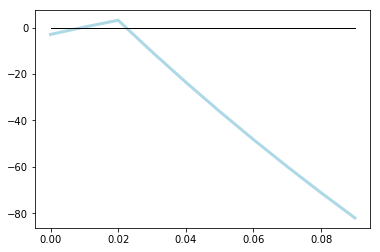

In [59]:
cashflows = [-100, 405, -500, 200, -100, 100]

print(cashflows)
print(sum(cashflows))
discount_rates_subset = discount_rates[0:10]
NPVs = [real_life_NPV(cashflows, borrow_rate = 0.02, reinvest_rate = i) for i in discount_rates_subset]
plt.plot(discount_rates_subset, NPVs, color='lightblue', linewidth=3)
plt.plot(discount_rates_subset, [0 for i in discount_rates_subset], color='black', linewidth=1)
plt.show()

Interestingly, we have 2 roots in this case.
<br>At first glance, we may want to automatically reject the root where return is < borrowing rate.
<br>However, this is realistic. If alternative projects return worse than the borrow rate, we want to pay down the loan as quickly as our primary project generates free cash flow.
<br>If we retain positive cash position during the project, then the best that project can recover is the reinvestment rate.

[-100, 50, 50, 50, 50, 50, 50]
200


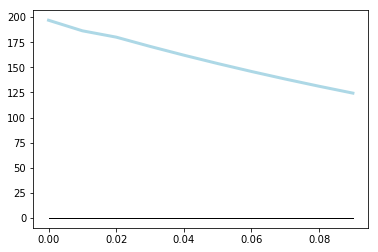

In [63]:
cashflows = [-100, 50, 50, 50, 50, 50, 50]

print(cashflows)
print(sum(cashflows))
discount_rates_subset = discount_rates[0:10]
NPVs = [real_life_NPV(cashflows, borrow_rate = 0.02, reinvest_rate = i) for i in discount_rates_subset]
plt.plot(discount_rates_subset, NPVs, color='lightblue', linewidth=3)
plt.plot(discount_rates_subset, [0 for i in discount_rates_subset], color='black', linewidth=1)
plt.show()